# Analysing Elo rating development in biased scenarios

Python 3.9.12

## Imports

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from __future__ import annotations

## Set seed

In [2]:
seed = 2

## Class: Player

### Description
Represents a player in a game using the Elo rating system. Attributes include player details, Elo ratings, and game statistics. Methods facilitate game outcome determination and Elo rating updates.

### Attributes
- **cheating_advantage_factor**: A constant (float) representing the increased win probability for cheaters. Default is 1.75.
- **name**: Player's name (str).
- **elo_group**: Player's group Elo rating (int).
- **elo_absolute**: Player's absolute Elo rating unaffected by cheating (int).
- **is_cheater**: Boolean flag indicating if the player is a cheater.
- **learning_rate**: Randomly generated float representing the player's learning rate.
- **game_counter**: Counter (int) for the number of games played.

### Methods
- **is_winner(competitor)**: Determines if the player wins against a competitor. Win probability is calculated using the Elo formula: $ P = \frac{1}{1 + 10^{(\text{elo_difference} / 400)}} $.
- **set_elo(elo_increment)**: Updates the player's group and absolute Elo ratings. Absolute Elo is adjusted by the learning rate for non-cheaters.
- **set_elo_expDecay(elo_increment)**: Experimental method for updating the Elo rating with exponential decay, not used in the main article.

In [3]:
np.random.seed(seed)

class Player:
    
    cheating_advantage_factor = 1.75  # +75% increase in win probability
    
    def __init__(self, name: str, elo: int, is_cheater: bool):
        self.name = name
        self.elo_group = elo
        self.elo_absolute = elo
        self.is_cheater = is_cheater
        self.learning_rate = np.random.random()
        self.game_counter = 0
        
    def is_winner(self, competitor: Player):
        self.game_counter += 1
        elo_difference = competitor.elo_absolute - self.elo_absolute
        base_win_probability = 1 / (1 + 10 ** (elo_difference / 400))

        if not self.is_cheater and competitor.is_cheater:
            adjusted_win_probability = max(base_win_probability * (1 / self.cheating_advantage_factor), 0)
            return np.random.random() <= adjusted_win_probability
        elif self.is_cheater and not competitor.is_cheater:
            adjusted_win_probability = min(base_win_probability * self.cheating_advantage_factor, 1)
            return np.random.random() <= adjusted_win_probability
        else:
            # Neither or both are cheaters
            return np.random.random() <= base_win_probability

    def set_elo(self, elo_increment: int):
        self.elo_group += elo_increment
        if not self.is_cheater:
            self.elo_absolute += self.learning_rate
        
    def set_elo_expDecay(self, elo_increment: int):
        # Alternative approach to set elo_absolute (not used in article)
        self.elo_group += elo_increment
        initial_growth_rate = 10
        if not self.is_cheater:
            self.elo_absolute += initial_growth_rate * math.exp(-(1-self.learning_rate) * self.game_counter)

## Simulation

In [4]:
elo_start = 800
n_players = 1000
cheater_ratio = 0.1
n_cheaters = int(n_players * cheater_ratio)

players = []
for i in range(n_players - n_cheaters):
    players.append(Player(name='Player_' + str(i), elo=elo_start, is_cheater=False))
    
for i in range(n_cheaters):
    players.append(Player(name='Cheater_' + str(i), elo=elo_start, is_cheater=True))

In [5]:
n_games = 200
elo_increment = 8
np.random.seed(seed)

elo_group_all_means = []
elo_group_qls_means = []
elo_abs_all_means = []
elo_abs_qls_means = []

elo_group_all_means_wCheaters = []
elo_group_qls_means_wCheaters = []
elo_abs_all_means_wCheaters = []
elo_abs_qls_means_wCheaters = []

for _ in range(n_games):
    np.random.shuffle(players)
    for i in range(0, len(players), 2):
        if i + 1 < len(players):
            p1 = players[i]
            p2 = players[i + 1]
            if p1.is_winner(p2):
                p1.set_elo(+elo_increment)
                p2.set_elo(-elo_increment)
            else:
                p1.set_elo(-elo_increment)
                p2.set_elo(+elo_increment)
    
    # Group Elo w/o cheaters
    # ----------------------
    # All players
    elo_group_all = [player.elo_group for player in players if not player.is_cheater]
    elo_group_all_means.append(np.mean(elo_group_all))
    # Quick learners
    elo_group_qls = [player.elo_group for player in players if not player.is_cheater and player.learning_rate >= 0.8]
    elo_group_qls_means.append(np.mean(elo_group_qls))
    
    # Absolue Elo w/o cheaters
    # ------------------------
    # All players
    elo_abs_all = [player.elo_absolute for player in players if not player.is_cheater]
    elo_abs_all_means.append(np.mean(elo_abs_all))
    # Quick learners
    elo_abs_qls = [player.elo_absolute for player in players if not player.is_cheater and player.learning_rate >= 0.8]
    elo_abs_qls_means.append(np.mean(elo_abs_qls))
    
    if n_cheaters > 0:
        
        # Group Elo w/ cheaters
        # ----------------------
        # All players
        elo_group_all_wCheaters = [player.elo_group for player in players]
        elo_group_all_means_wCheaters.append(np.mean(elo_group_all_wCheaters))
        # Quick learners
        elo_group_qls_wCheaters = [player.elo_group for player in players if player.learning_rate >= 0.8]
        elo_group_qls_means_wCheaters.append(np.mean(elo_group_qls_wCheaters))

        # Absolue Elo w cheaters
        # ------------------------
        # All players
        elo_abs_all_wCheaters = [player.elo_absolute for player in players]
        elo_abs_all_means_wCheaters.append(np.mean(elo_abs_all_wCheaters))
        # Quick learners
        elo_abs_qls_wCheaters = [player.elo_absolute for player in players if player.learning_rate >= 0.8]
        elo_abs_qls_means_wCheaters.append(np.mean(elo_abs_qls_wCheaters))

## Analysis

In [6]:
def plot_dist_kde(vector1, header1, vector2=None, header2=None, xlab="", ylab="", color1='blue', color2='red'):
    plt.figure(figsize=(10, 6))
    sns.kdeplot(vector1, color=color1, label=header1, fill=True)
    if vector2 is not None:
        sns.kdeplot(vector2, color=color2, label=header2, fill=True)
    
    plt.title(f"Distribution of Group Elo: {header1} vs {header2}" if header2 else header1)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.grid(True)
    if vector2 is not None:
        plt.legend()
    plt.show()

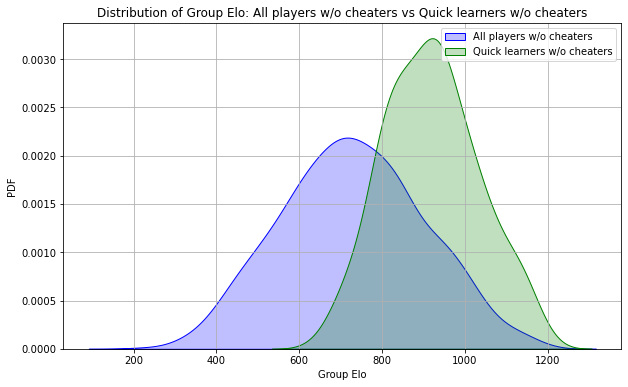

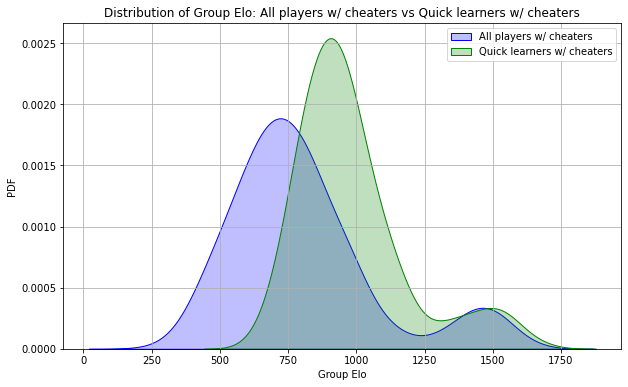

In [7]:
plot_dist_kde(elo_group_all, 'All players w/o cheaters', 
              elo_group_qls, 'Quick learners w/o cheaters',
              'Group Elo', 'PDF', 'blue', 'green')

if n_cheaters > 0:
    plot_dist_kde(elo_group_all_wCheaters, 'All players w/ cheaters', 
                  elo_group_qls_wCheaters, 'Quick learners w/ cheaters',
                  'Group Elo', 'PDF', 'blue', 'green')

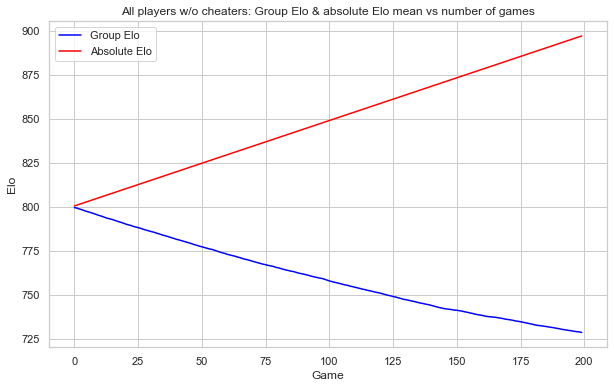

In [8]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.plot(elo_group_all_means, label='Group Elo', color='blue', marker='')
plt.plot(elo_abs_all_means, label='Absolute Elo', color='red', marker='')
plt.title('All players w/o cheaters: Group Elo & absolute Elo mean vs number of games')
plt.xlabel('Game')
plt.ylabel('Elo')
plt.legend()
plt.show()

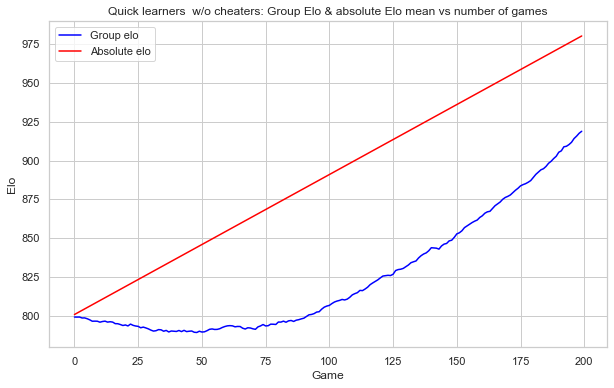

In [9]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.plot(elo_group_qls_means, label='Group elo', color='blue', marker='')
plt.plot(elo_abs_qls_means, label='Absolute elo', color='red', marker='')
plt.title('Quick learners  w/o cheaters: Group Elo & absolute Elo mean vs number of games')
plt.xlabel('Game')
plt.ylabel('Elo')
plt.legend()
plt.show()